<table style="width:100%"><tr>
<td> 
    
Technische Universität Berlin\
Electrical Engineering and Computer Science\
Internet of Things for Smart Buildings\
Prof. Dr. Sergio Lucia, Felix Fiedler, Benjamin Karg </td>
<td>  <img src="logo_tu.png" style="width: 20%;" align="right"/> </td>
</tr>
</table>

***
**MPC 20 - Exercise 04**
***

# <span class="graffiti-highlight graffiti-id_gyr7sdu-id_4e2zaz6"><i></i>Please click here!</span>

# Continuous-time NMPC with orthogonal collocation on finite elements

In this exercise we will continue working with the Python library [CasADi](https://web.casadi.org/docs/)
and use it to implement MPC for **a nonlinear continuous-time system**: 

$$
\dot x = f(x,u)
$$

Note that last week we dealt with the **linear discrete-time formulation**:

$$
x_{k+1} = Ax_k+Bu_k
$$

The main difficulty with the ODE is that we need numerical integration. The simplest approach in this regard is the well known Euler integration, where:

$$
x_{k+1} = x_k + \Delta t f(x_k,u_k).
$$

In most cases, however, the integration error with this approach will prevent a successfull MPC implementation.
Instead we apply **orthogonal collocation on finite elements**, which we formally introduce and implement in the following.

But first we import the required Python packages:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from casadi import *

We also change some Matplotlib parameters to increase the font size. Here is some [information](https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html) on how this works.

In [2]:
mpl.rcParams['font.size'] = 16

## <span class="graffiti-highlight graffiti-id_ph0wtd1-id_77slszz"><i></i>Example system</span>
For this exercise we consider a non-linear "leaf spring" system, which can be modelled as:

$$
m \ddot{x} = -k_1 x - k_2 x^{3}+u
$$

Such a spring is used on car suspensions – the more it deflects, the stiffer it gets.

We write this second order ODE as a coupled system of first oder ODE's as follows:

\begin{align}
\dot x_1 &= x_2\\
\dot x_2 &= -k_1 x_1 - k_2 x_1^{3}+u
\end{align}

## <span class="graffiti-highlight graffiti-id_ph0wtd1-id_wdfijxo"><i></i>Task 01: Define the system with CasADi</span>
Here are some required parameters:

In [3]:
# Timestep
dt = 0.2

# Spring constants k_1 and k_2:
k = np.array([-1, 0.5])

# Dimensions of x and u:
nx = 2
nu = 1

- Introduce the symbolic variables ``x`` and ``u`` of appropriate dimension
- Write the expression ``xdot``, the right hand side of the ODE as defined above
- Create a CasADi function ``system`` which takes as input ``x``,``u`` and returns the evaluated expression ``xdot``

In [15]:
# Your code here!
x = SX.sym("x", nx)
u = SX.sym("u", nu)
xdot = vertcat(x[1], -k[0]*x[0] - k[1]*x[0]**3 + u)

system = Function('system',[x,u],[xdot])


<span class="graffiti-highlight graffiti-id_wxki9z8-id_w0qdmru"><i></i><button>Show Solution</button></span>

In contrast to previous week, we now have a continuous-time ordinary differential equation. To obtain the time-series of the states we thus need to use numerical integration. 

We use the CasADi interface of the state-of-the-art IDAS integrator ([Sundials](https://computing.llnl.gov/projects/sundials/idas)).


**Note that we cannot use this Integrator directly for MPC** (unless you want to implement single-shooting or multiple-shooting). 
We use the Integrator **only for simulating the system**.

In [18]:
ode = {'x': x, 'ode': xdot, 'p': u}

# By default the solver integrates from 0 to 1. We change the final time to dt.
opts = {'tf': dt}

# Create the solver object.
ode_solver = integrator('F', 'idas', ode, opts)
print(ode_solver)

F:(x0[2],p,z0[0],rx0[0],rp[0],rz0[0])->(xf[2],qf[0],zf[0],rxf[0],rqf[0],rzf[0]) IdasInterface


The obtained ``ode_solver`` is a function that can be called with the initial state ``x0`` and the integration parameters ``p``. We use the parameters to pass the current input ``u``.

Let's see how the uncontrolled system behaves. 

## Task 02: Simulate the system
In this task we ask you to simulate the **uncontrolled** system, to get a feeling for the system behavior. 

Below we define
- ``N_sim`` - the total number of simulation steps
- ``x_0`` - the inital state of the system
- ``u_k`` - the control input at **all time instances** (uncontrolled system)

we furthermore initiate a list ``res_x_sundials`` to store the result of the simulation.

In [27]:
# Define the total steps to simulate
N_sim = 100
# Define the initial condition
x_0 = np.array([-2,1]).reshape(nx,1)
# Define the input (for the moment consider u = 0)
u_k = np.array([[0]])

res_x_sundials = [x_0]

**In  a loop:**
- call the ``ode_solver`` passing the current initial state and control input.
- extract the final state of the integration window from the returned dictionary
- store the new state
- update the initial state

Finally, concatenate the list ``res_x_sundials`` to obtain a ``numpy.ndarray``.

In [29]:
# Your code here!
res_x_sundials = [x_0]
for k in range(N_sim):
    sol = ode_solver(x0 = x_0, p = u_k)
    x_f = sol['xf']
    res_x_sundials.append(x_f)
    x_0 = x_f

res_x_sundials = np.concatenate(res_x_sundials, axis = 1)
print(res_x_sundials)

[[ 2.14429703  1.98198875  1.74365727  1.4682988   1.18724215  0.91924791
   0.67185538  0.44491354  0.23382908  0.03177078 -0.16902567 -0.37643711
  -0.59770339 -0.83831539 -1.10014099 -1.37848329 -1.65846967 -1.91261641
  -2.10330202 -2.19348286 -2.1628119  -2.01841729 -1.79098673 -1.51970581
  -1.23791414 -0.96668954 -0.71537424 -0.48495015 -0.27143864 -0.06829849
   0.13213453  0.33776974  0.55602822  0.7928327   1.05089935  1.32699125
   1.60834871  1.86980731  2.07505036  2.18578257  2.17747479  2.05206215
   1.83687831  1.57080155  1.28897345  1.01482108  0.75960542  0.52556093
   0.3094018   0.10492366 -0.09540957 -0.29951499 -0.51496503 -0.74805838
  -1.00226556 -1.27568894 -1.55757735 -1.82511621 -2.04360718 -2.17404293
  -2.18817134 -2.08269791 -1.88110344 -1.6214258  -1.34033883 -1.06361981
  -0.80456601 -0.56678164 -0.3477625  -0.14169108  0.0588101   0.26164264
   0.4744994   0.70400445  0.95430102  1.22470953  1.50637151  1.7788159
   2.00920652  2.15836035  2.19480899  

<span class="graffiti-highlight graffiti-id_cjntldr-id_s3polyd"><i></i><button>Show Solution</button></span>

We have prepared the following plot for you to investigate the state trajectories of the uncontrolled system. The system shows stable but undamped oscillations.

Text(0.5, 0, 'time')

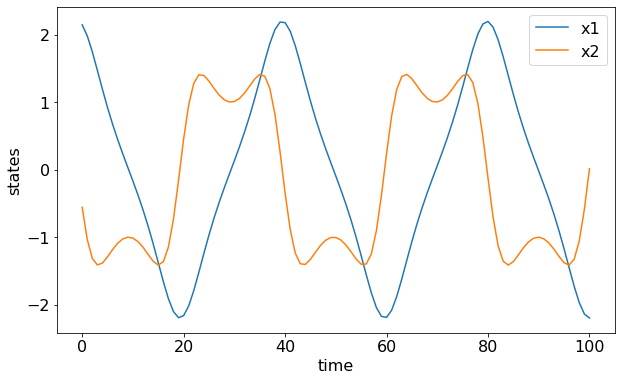

In [31]:
fig, ax = plt.subplots(figsize=(10,6))

# plot the states
lines = ax.plot(res_x_sundials.T)
ax.legend(lines, ['x1', 'x2'])


# Set labels
ax.set_ylabel('states')
ax.set_xlabel('time')

# <span class="graffiti-highlight graffiti-id_1qxsy6u-id_1mt4exi"><i></i>Lagrange Polynomials</span>
Fundamental for orthogonal collocation is the idea that the solution of the ODE:

$$
\dot{x} = f(x), \quad x(0)=x_0,
$$

which is $x(t)$, can be approximated accurately with a polynomial of order $K+1$:

$$
x^K_i(t) = \alpha_0 + \alpha_1 t + \dots + \alpha_{K}  t^K
$$

This approximation should be valid on small time-intervals $t\in [t_i, t_{i+1}]$, which
are the **finite elements** mentioned in the title.

The interpolation is based on $j=0,\dots,K$ interpolation points $(t_j, x_{i,j})$ in the interval $[t_i, t_{i+1}]$.
We are using the **Lagrange interpolation polynomial**:

\begin{align}
&x^K_i(t) = \sum_{j=0}^K L_j(\tau) x_{i,j}\\
\text{where:}\quad
&L_j(\tau) = \prod_{
\begin{array}{c}k=0\\ k \neq j \end{array}
}^K \frac{(\tau-\tau_k)}{(\tau_j-\tau_k)}, \quad &\tau = \frac{t-t_i}{\Delta t_i}, \quad \Delta t_i=t_{i+1}-t_i.
\end{align}

We call $L_j(\tau)$ the Lagrangrian basis polynomial with the dimensionless time $\tau \in [0,1]$. Note that the basis polynomial $L_j(\tau)$ is constructed to be $L_j(\tau_j)=1$ and $L_j(\tau_i)=0$ for all other interpolation points $i\neq j$.

In the following **we will allways choose** $\tau_0=0,\ \tau_j<\tau_{j+1}\leq 1,\ j=0,\dots,K-1$.

## <span class="graffiti-highlight graffiti-id_jals6xc-id_79wsab4"><i></i>Task 03: Simple Interpolation</span>
Before we use Lagrange polynomials to solve the ODE (with or without MPC), let's validate that they actually work as advertised ...

1. Implement the function ``L(tau_col, tau, j)`` which returns $L_j(\tau)$ for a given list of collocation points.

In [33]:
# Your code here!

def L(tau_col, tau, j):
    L_j = 1
    for k in range(len(tau_col)):
        if k!=j:
            L_j *= (tau-tau_col[k])/(tau_col[j]-tau_col[k])
    return L_j

<span class="graffiti-highlight graffiti-id_1ljwiv8-id_5tchtgm"><i></i><button>Hide Solution</button></span>

In [ ]:
def L(tau_col, tau, j):
    l = 1
    for k in range(len(tau_col)):
        if k!=j:
            l *= (tau-tau_col[k])/(tau_col[j]-tau_col[k]) 
    return l


2. Implement ``LgrInter(tau_col, tau, xk)``, which evaluates $x^K_i(t)$.

In [34]:
# Your code here!
def LgrInter(tau_col, tau, xk):
    xk_i = 0
    for j in range(len(xk)):
        xk_i += L(tau_col, tau, j)*xk[j, :]
    return xk_i

<span class="graffiti-highlight graffiti-id_k56jdhr-id_hn3cvra"><i></i><button>Hide Solution</button></span>

In [ ]:
def LgrInter(tau_col, tau, xk):
    z = 0
    for j in range(K):
        z += L(tau_col, tau, j)*xk[j,:]
        
    return z


We call the function ``LgrInter`` which returns the evaluated Lagrange polynomial.

In [36]:
# collocation degree.
K = 3

# Fix the random seed (results are always the same)
np.random.seed(1234)

# Get some linearly spaced collocation points between 0 and 1.
tau_col = np.linspace(0,1, num=K)
# Get some xk values for the collocation points.
xk = np.random.randn(K,2)

# Get the evaluated interpolation polynomial.
tau = np.linspace(0,1,100).reshape(-1,1)
x_interpolation = LgrInter(tau_col, tau, xk)


[[ 0.47143516 -1.19097569]
 [ 1.43270697 -0.3126519 ]
 [-0.72058873  0.88716294]]


and plot the results:

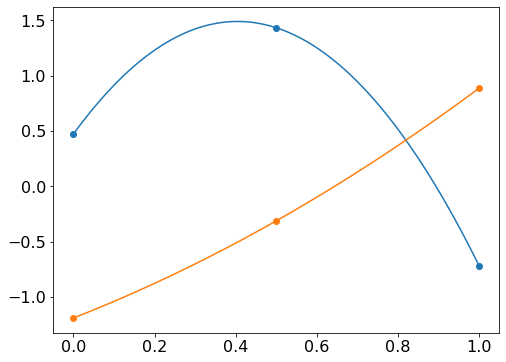

In [37]:
fig, ax= plt.subplots(figsize=(8,6))

ax.plot(tau, x_interpolation)
ax.set_prop_cycle(None)
ax.plot(tau_col, xk,'o')

The Lagrange polynomials perfectly fit the supplied data points.

## <span class="graffiti-highlight graffiti-id_f7bh7gs-id_pirw6vy"><i></i>Solving the ODE with orthogonal collocation</span>
Based on Lagrange polynomials we will now introduce orthogonal collaction and use it to solve an ODE.

<img src="./figures/orthogonal_collocation.svg" style="width: 70%;" align="center"/>

So far we have seen how to approximate an ODE solution
with Lagrange polynomials **given a set of values from the solution**.
This may seem confusing because we are looking for these values in the first place.
However, it still helps us because we can now state conditions based on this polynomial representation
that **must hold for the desired solution**:

$$
\left.\frac{d x^K_i}{dt}\right|_{t_{i,k}} = f(x_{i,k}), \quad k=1,\dots,K.
$$


This means that the time derivatives from our polynomial approximation evaluated
**at the collocation points** must be equal to the original ODE at these same points.
**Note** that we excluded the collocation point $\tau_0=0$, which is treated seperately.

Because we assumed a polynomial structure of $x^K_i(t)$ the time derivative can be conveniently expressed as:

$$
\left.\frac{d x^K_i}{dt}\right|_{t_{i,k}} = \sum_{j=0}^K \frac{x_{i,j}}{\Delta t}
    \underbrace{\left.\frac{d L_j}{d \tau}\right|_{\tau_k}}_{a_{j,k}},
$$

for which we substituted $t$ with $\tau$ (dimensionless time between 0 and 1).
It is important to notice that **for fixed collocation points** the terms $a_{j,k}$
**are constants that can be pre-computed.**
The choice of these points is significant and will be discussed later in this notebook.

### Collocation constraints


The solution of the ODE, i.e. the values of $x_{i,j}$ are now obtained by solving
the set of equations:

$$
\sum_{j=0}^K a_{j,k} \frac{x_{i,j}}{\Delta t} = f(x_{i,k}), \quad k=1,\dots,K.
$$



### Collocation with orthogonal polynomials

Above we used Lagrange polynomials to interpolate on arbitrary **collocation** points. 
To solve an ODE, it shows that certain **collocation** points are better than others.

Favorable properties are obtained when choosing the collocation points as the roots of a $K$-th degree **Gauss-Jacobi** polynomial:

$$
\int_0^1 (1-\tau)^{\alpha} \tau^{\beta} P_i(\tau) P_{j}(\tau) = 0, \quad i=0,\dots, K-1,\ j=1,\dots, K
$$

which is a general class of **orthogonal polynomials**. Specific cases of this polynomial are obtained for $\alpha=0,\ \beta=0$ (**Legrende polynomial**) and for $\alpha=1,\ \beta=0$ (**Radau**) polynomial. 

We don't want to discuss here, why these collocation points are favorable or how to compute them. In practize we can just obtain the values from tables and fortunately they are also available from CasADi:

In [38]:
print(collocation_points(K,'radau'))
print(collocation_points(K,'legendre'))

[0.15505102572168222, 0.6449489742783179, 1.0]
[0.11270166537925824, 0.5, 0.8872983346207417]


Note that these collocation points do not include $\tau_0=0$. For a given collocation degree $K$, we append:

In [39]:
# collocation degree
K = 2 

# collocation points (excluding 0)
tau_col = collocation_points(K,'radau')

# collocation points (including 0)
tau_col = [0]+tau_col

print(tau_col)

[0, 0.33333333333333337, 1.0]


We now want to implement the collocation constraints:

$$
\sum_{j=0}^K a_{j,k} \frac{x_{i,j}}{\Delta t} = f(x_{i,k}), \quad k=1,\dots,K.
$$

For this we compute the coefficients 

$$a_{j,k} = \left.\frac{d L_j}{d \tau}\right|_{\tau_k},$$ 

which we store in the matrix $A$, where:

$$
A_{i,j} = a_{i,j}
$$

## <span class="graffiti-highlight graffiti-id_x69hclv-id_k76xmtu"><i></i>Task 04:  Calculate orthogonal collocation coefficients</span>
Calculate the orthogonal collocation coefficients $a_{j,k}$ and store them in a matrix $A$.
You can use CasADi and should introduce the symbolic variable $\tau$ and use your previously written function ``L(tau_col, tau, j)``. 

In [52]:
# Your code here!
tau = SX.sym("tau")
A = np.zeros((K+1,K+1))
for j in range(K+1):
    dLj = gradient(L(tau_col, tau, j), tau)
    dLj_fcn = Function('dLj_fcn', [tau], [dLj])
    for k in range(K+1):
        A[j][k] = dLj_fcn(tau_col[k])

print(A)

[[-4.  -2.   2. ]
 [ 4.5  1.5 -4.5]
 [-0.5  0.5  2.5]]


<span class="graffiti-highlight graffiti-id_vsv38zw-id_jvmj1oj"><i></i><button>Hide Solution</button></span>

In [ ]:
tau = SX.sym('tau')

A = np.zeros((K+1,K+1))

for j in range(K+1):
    dLj = gradient(L(tau_col, tau, j), tau)
    dLj_fcn = Function('dLj_fcn', [tau], [dLj])
    for k in range(K+1):
        A[j,k] = dLj_fcn(tau_col[k])
        


For $K=2$ and Radau collocation points you should obtain:
```python
A
>> array([[-4. , -2. ,  2. ],
          [ 4.5,  1.5, -4.5],
          [-0.5,  0.5,  2.5]])
```

With our choice of collocation points $\tau_0=0,\ \tau_j<\tau_{j+1}\leq 1,\ j=0,\dots,K-1$, we have included the initial state in the finite element **but not the final state**. 
We need the final state within a given finite element because this is the point from which the next finite element should start.
Given the collocation points and their respective values, we thus want to evaluate the interpolation polynomial:

$$
x_i^f = x^K_i(t_{i+1}) = \sum_{j=0}^K L_j(\tau=1) x_{i,j}
$$

Again, **we don't know $x_{i,j}$ yet**, but we can determine $d_j = L_j(\tau=1),\ j=0,\dots, K$.
**Note that $d_j$ is a constant for fixed collocation points.**

We store the values of $d_j$ in the vector $D$.

## <span class="graffiti-highlight graffiti-id_s9565eb-id_uvzmoif"><i></i>Task 05: Calculate continuity coefficients</span>
Caculate the coeffcient $d_j$ and store them in the vector $D$. Use CasAdi, the symbolic variable $\tau$ and your function ``L(tau_col, tau, j)``.

In [ ]:
# Your code here!

<span class="graffiti-highlight graffiti-id_ryn8j53-id_uhgf2ko"><i></i><button>Show Solution</button></span>

For $K=2$ and Radau collocation points you should obtain:
```python
D
>> array([[ 0.],
          [-0.],
          [ 1.]])
```
This shouldn't be surprising, as the Radau colloction points include $\tau_{K}=1$.

# <span class="graffiti-highlight graffiti-id_1nacdfa-id_epkdvkh"><i></i>Integration with orthogonal collocation</span>

Before we use orthogonal collocation for our MPC implementation, we investigate the method by **solving the previously introduced ODE and then compare it to the solution obtained with Sundials**. 

This is **just an illustrative example and not how we use orthogonal collocation in practize**. 

To integrate an ODE with orthogonal collocation from $(t_i, x_{i,\text{init}})$ to $(t_{i+1}, x_i^f)$
we introduce the following optimization problem:

\begin{align}
&\min_{x_{i,0},\dots, x_{i,K}} \quad &0\\
&\text{s.t.} &\sum_{j=0}^K a_{j,k} x_{i,j} - \Delta t f(x_{i,k})=0, \quad k=1,\dots,K\\
& &x_{i,0} = x_{i,\text{init}}
\end{align}

where $x_i^f$ is obtained from 

$$
x_i^f = \sum_{j=0}^K d_j x_{i,j}.
$$

Note that for this simple integration application **we only consider a single finite element**. 
Continuity is enforced by repeatedly solving the optimization problem with updated initial state $(t_i, x_{i,\text{init}})$.

## Task 06: Create an optimization problem to solve the collocation problem
Implement the described optimization problem with CasADi. 


1. Introduce symbolic variables
    - ``X`` - the states at all collocation points
    - ``x_init`` - the initial state
    - ``u`` - the constant control input over the finite element
2. Use ``x_init`` as an equality constraint for the first state $x_{i,0}$
3. Append collocation constraints
4. Concatenate constraint vector ``g`` (make vector from list)
5. Create an CasADi ``nlpsol`` object that can be used to solve the problem.

In [ ]:
# Initialize empty list of constraints
g = []

# 01 - Your code here!

# 01


# 02 - Your code here!

# 02


# 03 - Your code here!

# 03


# 04 - Your code here!    

# 04


# 05 - Your code here!

# 05

<span class="graffiti-highlight graffiti-id_v9bqjwx-id_2o3ipwi"><i></i><button>Show Solution</button></span>

## Task 07: Solve the ODE with orthogonal collocation
We define the initial state and control input as above, when we first investigated the system response.

In [ ]:
# Define the initial condition
x_0 = np.array([-2,1]).reshape(2,1)
# Define the input (for the moment consider u = 0)
u_k = np.array([[0]])

# Initialize result list
res_x_oc = [x_0]

**In a loop:**
- call the previously created optimizer ``nlpsol``with the current initial state and control input. The upper and lower bound for ``g`` are zero (equality constraints).
- Extract the solution ``X``.
- Obtain $x_i^f$ (the state at $\tau = 1 $ with the previously created $d_j = L_j(\tau=1)\ j=0,\dots, K$.
- Store the new final state $x_i^f$.
- Update the initial state.

Afterwards concatenate the ``res_x_oc`` such that is a ``numpy.ndarray`` with:
```python
res_x_oc.shape
>> (nx, N_sim)
```

In [ ]:
# Your code here!

<span class="graffiti-highlight graffiti-id_tbdy9zq-id_1osdafo"><i></i><button>Show Solution</button></span>

We have prepared this plot to compare the orthogonal collocation result with the Sundials results from above.

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

# plot the states
ax.plot(res_x_sundials.T, alpha=0.5, linewidth=6)
ax.set_prop_cycle(None)
ax.plot(res_x_oc.T)


# Set labels
ax.set_ylabel('states')
ax.set_xlabel('time')
ax.set_title('Orthogonal collocation vs. Sundials')

Orthogonal collocation yields very good results but we can still see a minor **integration error**.

### Comparison with Euler integration
Just for fun (and as a daunting example) we also provide you the code for the very simple explicit Euler integration:

$$
x_{k+1} = x_k + \Delta t f(x_k,u_k).
$$

Note that we break the loop when the values exceed a certain threshold ...

In [ ]:
# Define the initial condition
x_0 = np.array([-2,1]).reshape(2,1)
# Define the input (for the moment consider u = 0)
u_k = np.array([[0]])

res_x_euler = [x_0]

for i in range(N_sim):
    x_next = x_0 + dt*system(x_0, u_k)
    res_x_euler.append(x_next)
    x_0 = x_next
    
    if np.any(np.abs(x_0.full())>1e3):
        break

# Make an array from the list of arrays:
res_x_euler = np.concatenate(res_x_euler,axis=1)

Here comes the corresponding plot.

In [ ]:
fig, ax = plt.subplots(figsize=(10,6))

# plot the states
ax.plot(res_x_sundials.T, alpha=0.5, linewidth=6)
ax.set_prop_cycle(None)
ax.plot(res_x_euler.T)

ax.set_ylim(-2.5,2.5)


# Set labels
ax.set_ylabel('states')
ax.set_xlabel('time')

ax.set_title('Euler Integration vs. Sundials')

Needless to say: **Euler integration is a bad idea** in this case (or in most other cases for this matter) ...

We hope you get the hint and don't use Euler integration in your projects :D 

# <span class="graffiti-highlight graffiti-id_9ski5e9-id_ylvhwcc"><i></i>MPC with orthogonal collocation</span>

We can now very easily extend our previous MPC implementation (for the discrete-time case) to the non-linear continuous example. 

**What is different?**
- the optimization problem includes the collocation constraints.
- For each time-interval (finite element) we have a constant control input but $K+1$ instances of the states at the different collocation points.
- Bounds for the states can be set for all collocation points or just for the state at $\tau = 0$.
- the cost function can be evaluated for all collocation points or just for the state at $\tau = 0$.

Here, we decide to evaluate the cost function only at $\tau = 0$ and set upper and lower bounds for the states for all collocation points. 

With these differences in mind, we follow the scheme from last week and start by defining the cost function.

The objective of the MPC controller is again to regulate the system. To achieve this goal we use the same quadratic cost function, where for every time step $i$ of the horizon the following expression should be minimized:

$$l(x_{i,0},u_i) = x_{i,0}^T Q x_{i,0} + u_i^T R u_i $$

where Q and R are positive definite diagonal matrices. 
For the terminal cost we have a slightly altered expression:

$$ m(x_{N+1,0}) = x_{N+1,0}^T P x_{N+1,0}, $$ 

For simplicity we assume $P=Q$.

In [ ]:
Q = 20
Q = Q*np.diag(np.ones(nx))
print(Q)

In [ ]:
R = 10
R = np.diag(R*np.ones(nu))
print(R)

with these tuning matrices we create the stage and terminal cost function. Remember that the symbolic variables ``x`` and ``u`` were already introduced in the context of numerical integration with Sundials.

In [ ]:
# stage cost
stage_cost = x.T@Q@x+ u.T@R@u
stage_cost_fcn = Function('stage_cost',[x,u],[stage_cost])

# terminal cost
terminal_cost = x.T@Q@x
terminal_cost_fcn = Function('terminal_cost',[x],[terminal_cost])

Another important parameter to choose is the prediction horizon. This determines "how far we look into the future". Note that an optimal solution does not guarante stability. **Feel free to test other values for the horizon**.

In [717]:
N = 20

### Upper and lower bounds for stage variables:
These are suggested values that can be changed later.

In [775]:
# state constraints
lb_x = -4*np.ones((nx,1))
ub_x = 4*np.ones((nx,1))
# input constraints
lb_u = -0.4*np.ones((nu,1))
ub_u = 0.4*np.ones((nu,1))

## <span class="graffiti-highlight graffiti-id_0h20o1t-id_ibex9sa"><i></i>Define optimization variables</span>

The optimization variables are now taking a rather complicated form. We have $n_x$ states for $N$ finite elements and $K+1$ collocation points in each interval. Since CasADi requires **a single vector** we must also concatenate the $n_u \times N$ **inputs** with the $n_x \times N \times K+1$ **states**. 

**Indexing this stacked vector to obtain the desired elements is prone to error and cumbersome.**

To make our life easier, we will profit from another CasADi feature: **the structured symbolic variable**.  

First we must import the feature with:

In [ ]:
from casadi.tools import *

We can then define:

In [ ]:
opt_x = struct_symSX([
    entry('x', shape=nx, repeat=[N+1, K+1]),
    entry('u', shape=nu, repeat=[N])
])

This "optimization variable x" **contains the states and inputs for all time-steps and all collocation points**.
Let's quickly investigate it:

In [ ]:
print(opt_x)

We already get a lot of information. If we use:

In [ ]:
print(vertcat(opt_x))

and

In [ ]:
print(vertcat(opt_x).shape)

we see that it is in fact just the full vector of optimization variables. What makes this so useful is that we can use **power indexing**, e.g.:

In [ ]:
opt_x['x', 10, 2]

which gives the states $x_{10,2}$. For more information on CasADi structures, please read this [guide](http://casadi.sourceforge.net/v2.0.0/tutorials/tools/structure.pdf).

Another amazing feature of the CasADi structure is that we can call the structure ``opt_x()`` with numerical values, which will then **populate an identical numerical structure with these values**. You will see later that this is very convenient for extracting the solution of the MPC solver. 

For now we use it to define the bounds of ``x`` and ``u``. We initialize the bounds with:

In [ ]:
lb_opt_x = opt_x(0)
ub_opt_x = opt_x(0)

Which can now be indexed as the symbolic structure above. Note that we set all values to zero.

In [ ]:
lb_opt_x['x', 10, 2]

To set the desired values to our configured bounds we simply have to state:

In [ ]:
lb_opt_x['x'] = lb_x
ub_opt_x['x'] = ub_x

lb_opt_x['u'] = lb_u
ub_opt_x['u'] = ub_u

<span class="graffiti-highlight graffiti-id_3owaxvr-id_p7i2dhl"><i></i>Just a little addition to the previous recording ...</span>

Which **propagates to all repeated values** (collocation points and time-steps). We can quickly check some instances:

In [ ]:
lb_opt_x['x', 10, 2]

In [ ]:
ub_opt_x['x', 10, 2]

In [ ]:
lb_opt_x['u', 0]

This is exactly what we wanted! And again the numerical structures are just vectors of the same length as the optimization variables (once we use ``vertcat``):

In [ ]:
print(vertcat(ub_opt_x).shape)

## <span class="graffiti-highlight graffiti-id_c6spdcu-id_6z1h4kw"><i></i>Task 08: Formulate MPC optimization problem</span>
We are now prepared to formulate the MPC optimization problem, which consists of the cost ``J
``, the constraints ``g`` and the bounds. Since we have already configured the upper and lower bounds of the optimization variables, we only need to initialize:

In [ ]:
J = 0
g = []    # constraint expression g
lb_g = []  # lower bound for constraint expression g
ub_g = []  # upper bound for constraint expression g

We follow the same scheme as last week and loop over the different stages of our prediction horizon:

```python
for i in range(N):
    ...
```

and at each iteration we append the stage:
- cost
- constraints

in terms of the stage variables ``x_i`` and ``u_i``.
Fortunately, we have already defined the functions:

- ``stage_cost_fcn`` (stage cost)
- ``terminal_cost_fcn`` (terminal cost)
- ``system`` (right hand side of the ODE)

which now come very handy! 

The **dynamic state equation** is enforced by adding the collocation constraint at each stage:

$$
\sum_{j=0}^K a_{j,k} x_{i,j} - \Delta t f(x_{i,k})=0
$$

as well as 

$$
x_i^f = x_{i+1,0},
$$

where

$$
x_i^f = x^K_i(t_{i+1}) = \sum_{j=0}^K L_j(\tau=1) x_{i,j}.
$$

We also include a parameter ``x_init`` (CasADi symbolic variable) to enforce the initial state this time.
This is an alternative to resetting the bounds at each iteration, as we showed in the previous exercise.

The additional constraint is:

$$
x_{0,0} = x_{\text{init}}
$$

**Here is what you need to do:**

**Before the loop:**
1. Introduce the symbolic variable ``x_init`` and use it as an equality constraint for the first state $x_{0,0}$.

**At each stage $i$:**
2. Add the stage cost computed with $x_{i,0}, u_i$.
3. Add the collocation constraints.
4. Add the continuity constraints $x_i^f = \sum_{j=0}^K d_j x_{i,j} = x_{i+1,0}$.

**After the loop:**
5. Add the terminal cost
6. Concatenate ``g`` (must be a vector, not a list!) and create the CasADi ``nlpsol`` object.

In [ ]:
# 01 - Your code here!

# 01

for i in range(N):
    # 02 - Your code here!

    # 02
    
    
    # 03 - Your code here!

    # 03

    
    # 04 - Your code here!

    # 04
    

# 05 - Your code here!

# 05


# 06 - Your code here!

# 06

<span class="graffiti-highlight graffiti-id_mz7is9d-id_jvx6dy6"><i></i><button>Show Solution</button></span>

## <span class="graffiti-highlight graffiti-id_awmzi84-id_ikb0y1w"><i></i>Solving the optimal control problem</span>
Before we run the MPC loop, we again investigate the solution of a **single optimizer call**.
We have prepared the call for you below.

Note that we are passing the initial state as a parameter. Furthermore, we have ``lbg=0`` and ``ubg=0`` and we need to pass our pre-configured structures for the upper and lower bounds on the optimization variables.

In [ ]:
# Define the initial condition
x_0 = np.array([-2,1]).reshape(2,1)
mpc_res = mpc_solver(p=x_0, lbg=0, ubg=0, lbx = lb_opt_x, ubx = ub_opt_x)

Again we want to see:

```
EXIT: Optimal Solution Found.
```

otherwise the solution is not to be trusted.

## Task 09: Extracting the solution
As shown above, we can now use our configured symbolic structure ``opt_x`` to structure the obtained solution.
We simply need to call:

In [ ]:
 opt_x_k = opt_x(mpc_res['x'])

This is very helpful because we can now conviniently query the solution. In this task, we ask you to extract the solution for the predicted sequence of states and inputs from the structure ``opt_x_k``.

For the states, we are only interested for the first collocation element: $x_{i,0},\ i =0,\dots,N+1$.

To be compliant with the prepared figure below, the resulting variables should have the dimension:

```python
X_k.shape
>> (2, N+1)
U_k.shape
>> (1, N)
```

**Hint:** You can use the slice operator ``:`` when indexing the structure.

In [ ]:
# Your code here!

<span class="graffiti-highlight graffiti-id_emgz5ab-id_3rc1pv8"><i></i><button>Show Solution</button></span>

### Visualizing the prediction
Below we plot the predicted states and inputs. 
We can see that the optimizer finds a solution that drives the states slowly to zero.
Furthermore, we observe that the constraints (visible for the inputs) are satisfied. 

**Note** that this is not MPC yet but **just the solution of a single optimal control problem**.

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(10,6))

# plot the states
ax[0].plot(X_k.T)
ax[1].plot(U_k.T)

# Set labels
ax[0].set_ylabel('states')
ax[1].set_ylabel('inputs')
ax[1].set_xlabel('time')

## <span class="graffiti-highlight graffiti-id_bnroe42-id_myd876j"><i></i>Task 10: Create and run MPC main loop</span>
Now that everything is working, we can finally run the MPC loop.
We choose the same initial state as before and initialize the lists for the results.

In [ ]:
# Define the initial state
x_0 = np.array([-2,1]).reshape(2,1)
# Initialize result lists for states and inputs
res_x_mpc = [x_0]
res_u_mpc = []

# Set number of iterations
N_sim = 50

**At each iteration:**
1. pass the current initial state as a parameter and call the solver ``mpc_solver``
2. extract the **current** control input from the optimal solution
3. similarly to **Task 02:** Simulate the system (with the obtained control input) and obtain the next state
4. reset the initial state to the next state
5. store the next state and current control input to ``res_x_mpc`` and ``res_u_mpc``

Finally, concatenate the list ``res_x_mpc`` and ``res_u_mpc`` to obtain a ``numpy.ndarray``.


**NEVER** extract from the MPC results the next state of the system. **This is very important**. No matter how accurate your discretization scheme, you will always introduce an error. The real system development should always be obtained from a designated simulator, such as Sundials (or from measurements). The MPC results should only be considered a **prediction** of the future development of the system.

In [ ]:
for i in range(N_sim):
    # 01 - Your code here!

    # 01
        
        
    # 02 - Your code here!

    # 02

    
    # 03 - Your code here!

    # 03
    
    
    # 04 - Your code here!

    # 04
    
    
    # 05 - Your code here!    

    # 05
    

<span class="graffiti-highlight graffiti-id_3nthzme-id_jq9qtbr"><i></i><button>Show Solution</button></span>

Here is the final plot of this exercise, showing the recorded sequence of states and inputs over time. The controller clearly suceeds in regulating the system and also obeys our set bounds.

In [ ]:
fig, ax = plt.subplots(2,1, figsize=(10,6))

# plot the states
ax[0].plot(res_x_mpc.T)
ax[1].plot(res_u_mpc.T)

# Set labels
ax[0].set_ylabel('states')
ax[1].set_ylabel('inputs')
ax[1].set_xlabel('time')

Thank you very for following through this last exercise of the class. We hope you are now well prepared to succeed in your projects and in future work with model predictive control.

<span class="graffiti-highlight graffiti-id_qv29bnp-id_ixcnuxo"><i></i>Please like and subscribe :D</span>

(sorry this is the closest I will ever get to a Youtuber's career haha)